In [2]:
# cd ..

/home/oriol_hi/tutorials/sma_miniproject


/home/oriol_hi/.local/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [25]:
import xarray as xr
import numpy as np
import zarr
from dask.diagnostics import ProgressBar

# Load the dataset (use Dask for large files)
ds = xr.open_dataset("data/SST.nc", chunks={'lat': 224, 'lon': 224})  # Adjust chunking as needed

# Get the dimensions for latitude, longitude, and time
latitudes = ds.lat.values
longitudes = ds.lon.values
time = ds.time.values

tile_size = 224  # Tile size, change as needed

# Create a Zarr store for the output
store = zarr.open("tiles_output.zarr", mode="w")

# Calculate the number of tiles needed in each dimension
n_tiles_lat = (len(latitudes) + tile_size - 1) // tile_size
n_tiles_lon = (len(longitudes) + tile_size - 1) // tile_size

# Create empty arrays to hold the tiled data
# Store each variable (analysed_sst, sea_ice_fraction, etc.) in separate arrays
sst_array = store.create('analysed_sst', shape=(len(time), n_tiles_lat, n_tiles_lon, tile_size, tile_size),
                         dtype='float32', chunks=(1, 1, 1, tile_size, tile_size))
lat_array = store.create('latitudes', shape=(len(time), n_tiles_lat, n_tiles_lon, tile_size, tile_size),
                         dtype='float32', chunks=(1, 1, 1, tile_size, tile_size))
lon_array = store.create('longitudes', shape=(len(time), n_tiles_lat, n_tiles_lon, tile_size, tile_size),
                         dtype='float32', chunks=(1, 1, 1, tile_size, tile_size))

# Split the dataset into tiles and fill the Zarr store
for t_idx in range(len(time)):
    # Select the current time step
    sst_t = ds.analysed_sst.isel(time=t_idx)
    sea_ice_t = ds.sea_ice_fraction.isel(time=t_idx)
    
    # Iterate over latitude and longitude to extract tiles
    for lat_idx in range(0, len(latitudes), tile_size):
        for lon_idx in range(0, len(longitudes), tile_size):
            # Ensure that the slice does not go out of bounds by using min()
            lat_end = min(lat_idx + tile_size, len(latitudes))
            lon_end = min(lon_idx + tile_size, len(longitudes))
            
            # Extract the tiles for SST and sea ice fraction (with padding if needed)
            sst_tile = sst_t.sel(lat=slice(latitudes[lat_idx], latitudes[min(lat_idx + tile_size, len(latitudes)) - 1]),
                                 lon=slice(longitudes[lon_idx], longitudes[min(lon_idx + tile_size, len(longitudes)) - 1]))
            sea_ice_tile = sea_ice_t.sel(lat=slice(latitudes[lat_idx], latitudes[min(lat_idx + tile_size, len(latitudes)) - 1]),
                                         lon=slice(longitudes[lon_idx], longitudes[min(lon_idx + tile_size, len(longitudes)) - 1]))

            # Create padded tiles if the last tile doesn't fit
            sst_tile_padded = np.pad(sst_tile.values, ((0, tile_size - sst_tile.shape[0]), (0, tile_size - sst_tile.shape[1])), 
                                     mode='wrap')  # Using 'wrap' mode to repeat data at edges
            sea_ice_tile_padded = np.pad(sea_ice_tile.values, ((0, tile_size - sea_ice_tile.shape[0]), 
                                                                 (0, tile_size - sea_ice_tile.shape[1])), 
                                         mode='wrap')

            # Get the corresponding latitude and longitude slices, also padded
            lat_tile_padded = np.pad(latitudes[lat_idx:lat_end], (0, tile_size - len(latitudes[lat_idx:lat_end])), 
                                     mode='wrap')
            lon_tile_padded = np.pad(longitudes[lon_idx:lon_end], (0, tile_size - len(longitudes[lon_idx:lon_end])), 
                                      mode='wrap')

            # Store the padded data into the Zarr arrays
            sst_array[t_idx, lat_idx//tile_size, lon_idx//tile_size] = sst_tile_padded
            lat_array[t_idx, lat_idx//tile_size, lon_idx//tile_size] = np.tile(lat_tile_padded, (tile_size, 1)).T
            lon_array[t_idx, lat_idx//tile_size, lon_idx//tile_size] = np.tile(lon_tile_padded, (tile_size, 1))


print("All tiles have been saved in Zarr format.")


/tmp/ipykernel_3510755/2745450728.py:7: UserWarning: The specified chunks separate the stored chunks along dimension "lat" starting at index 224. This could degrade performance. Instead, consider rechunking after loading.
  ds = xr.open_dataset("data/SST.nc", chunks={'lat': 224, 'lon': 224})  # Adjust chunking as needed
/tmp/ipykernel_3510755/2745450728.py:7: UserWarning: The specified chunks separate the stored chunks along dimension "lon" starting at index 224. This could degrade performance. Instead, consider rechunking after loading.
  ds = xr.open_dataset("data/SST.nc", chunks={'lat': 224, 'lon': 224})  # Adjust chunking as needed


All tiles have been saved in Zarr format.


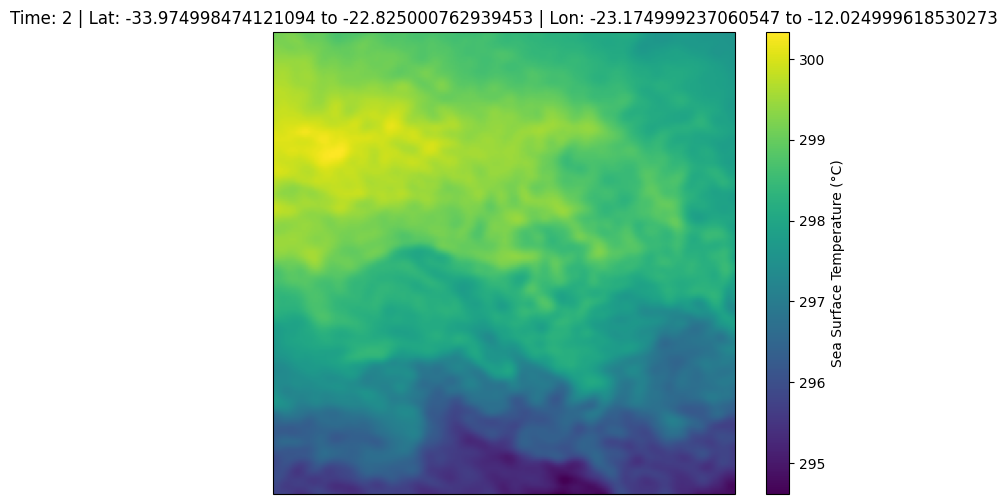

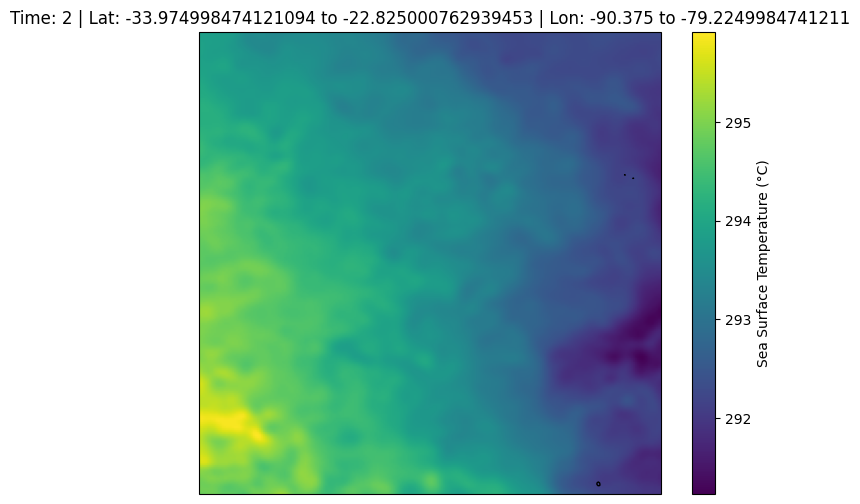

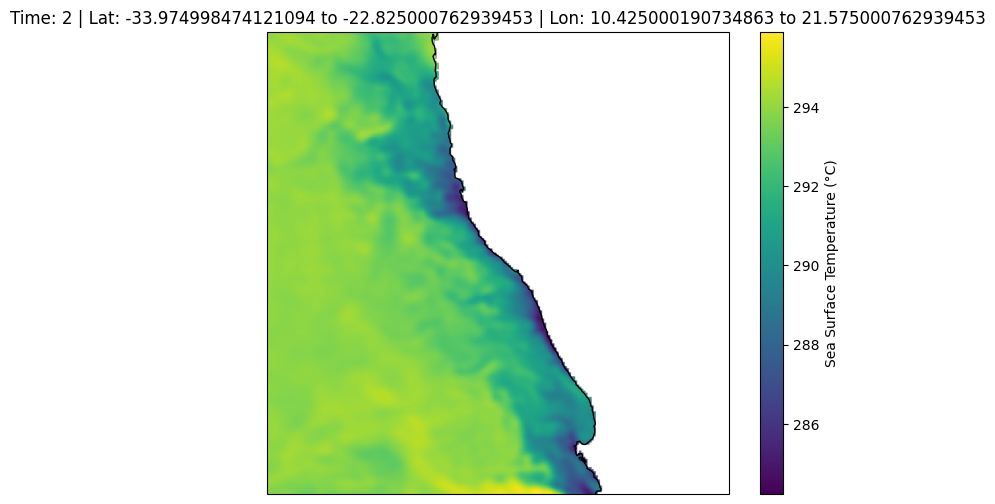

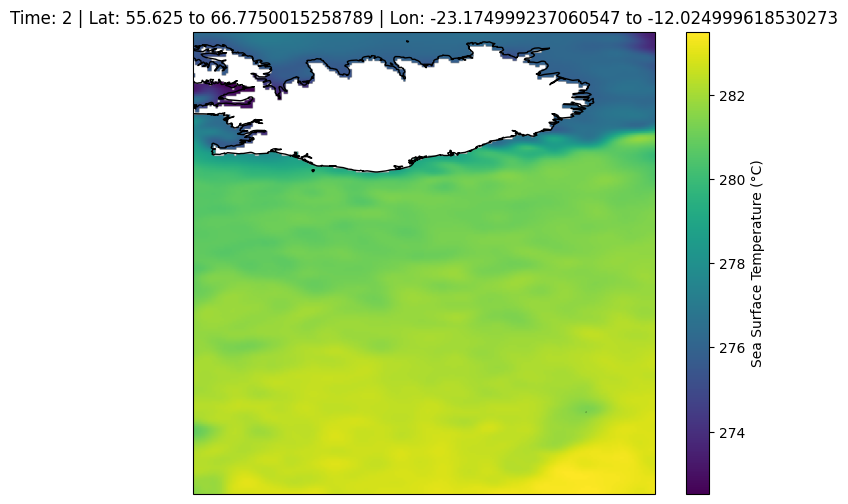

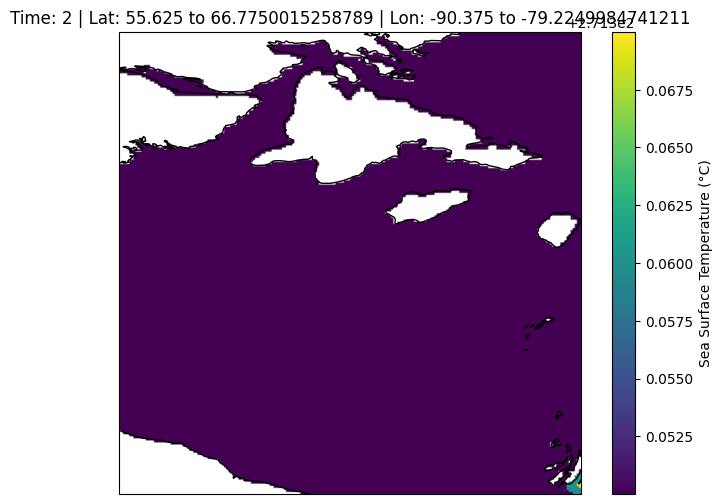

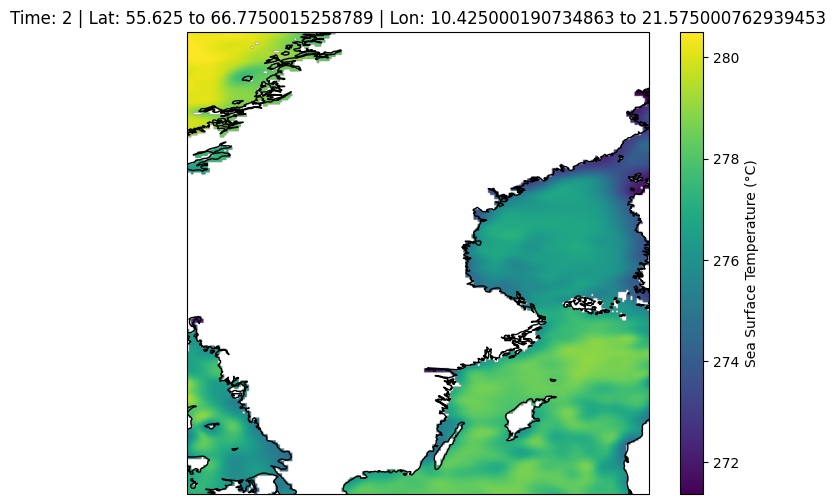

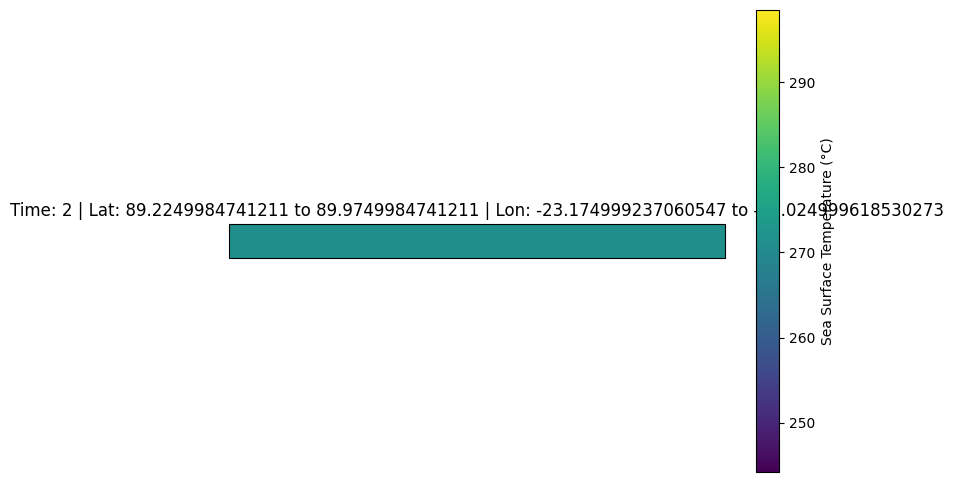

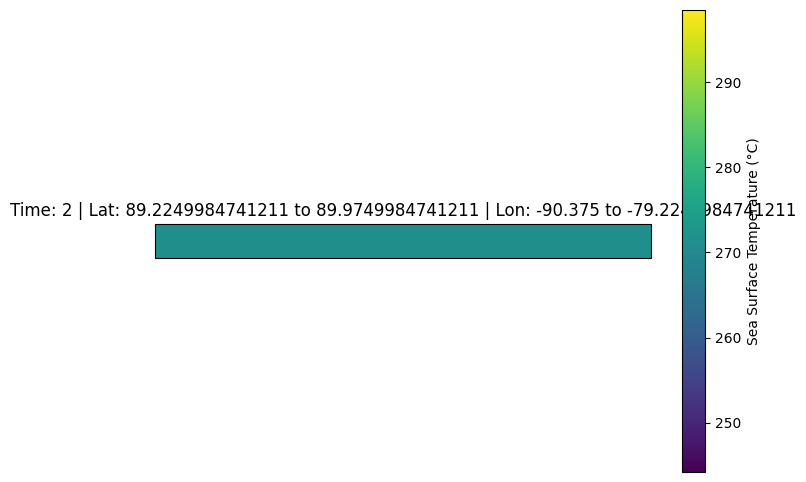

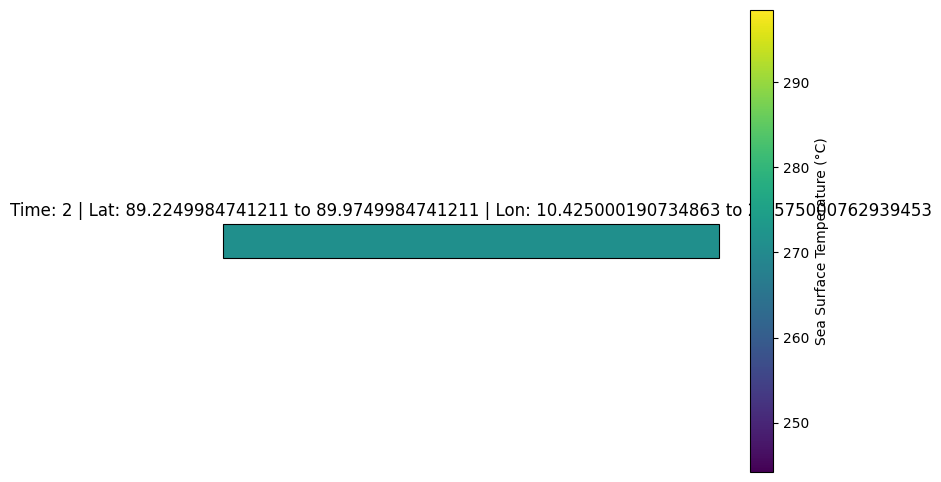

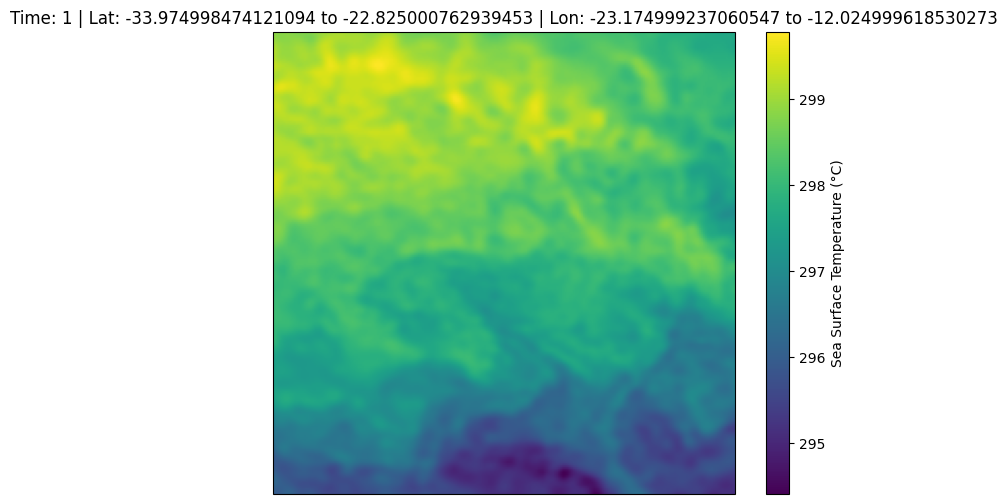

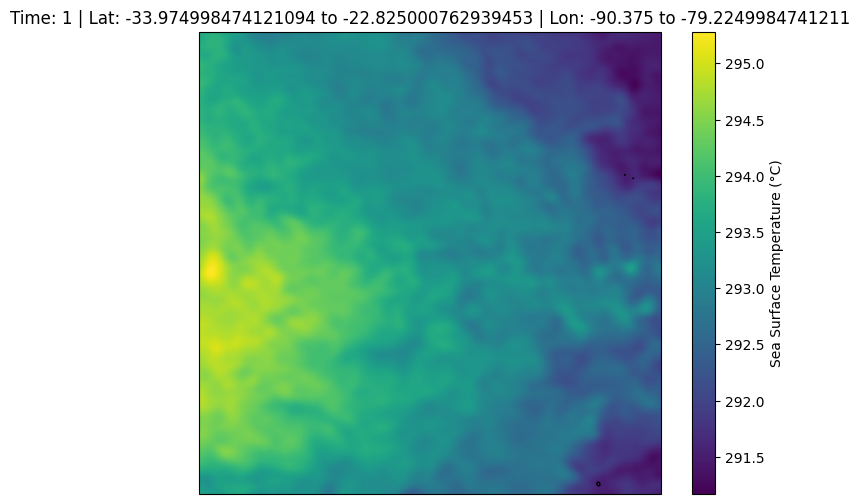

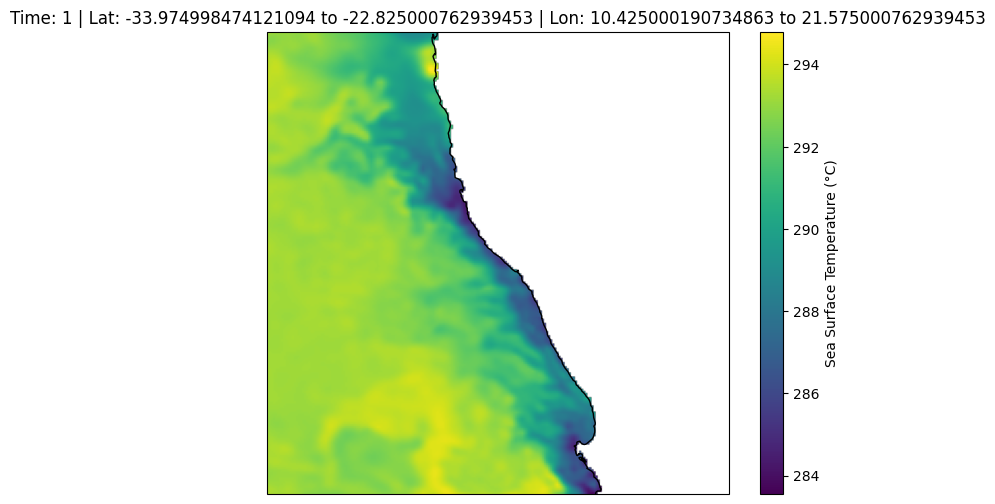

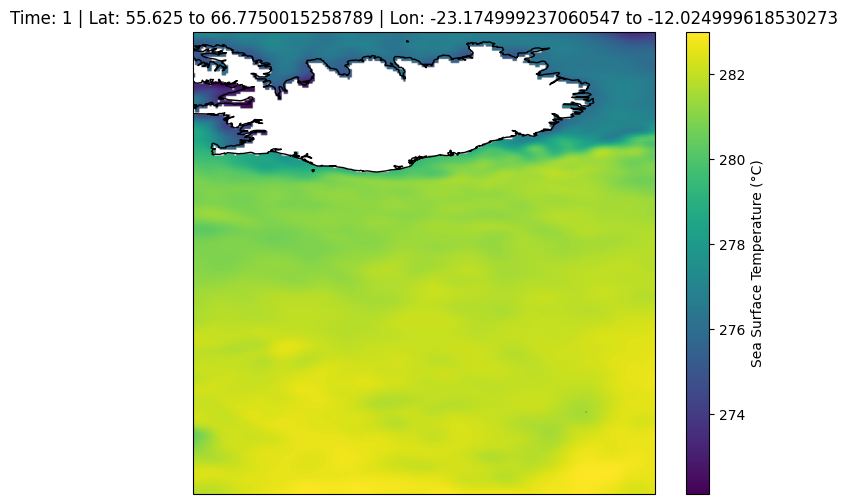

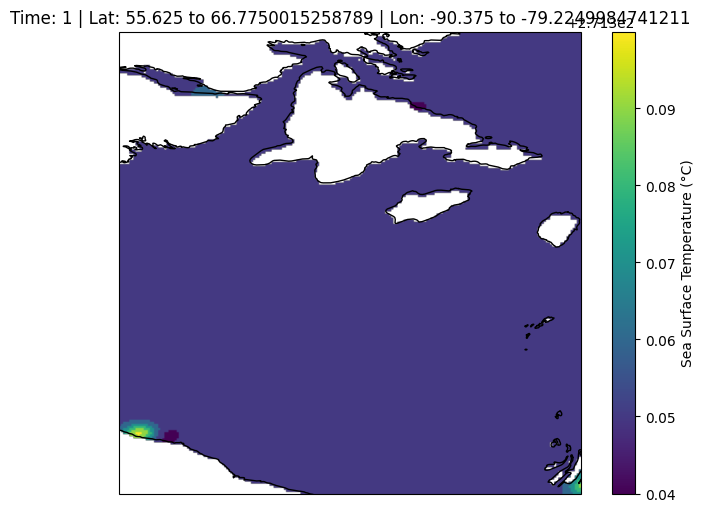

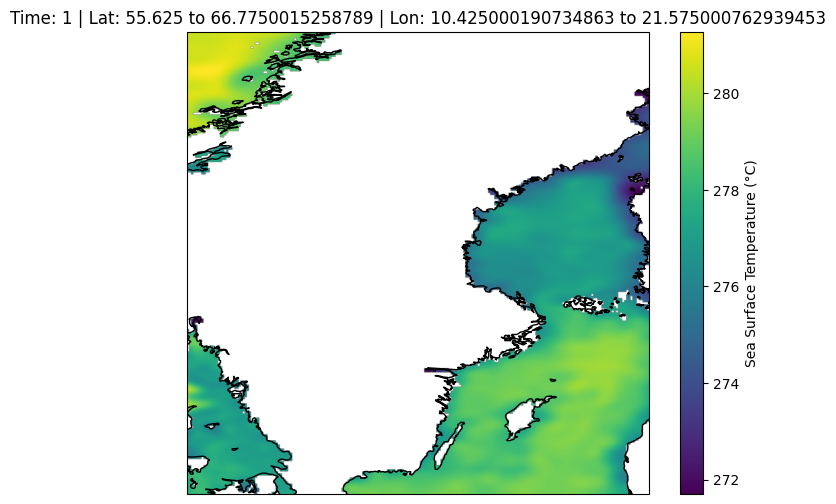

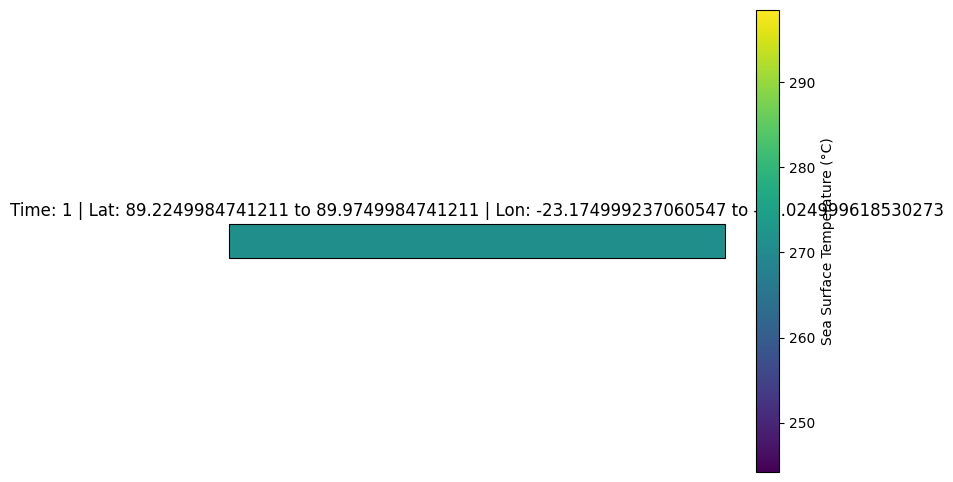

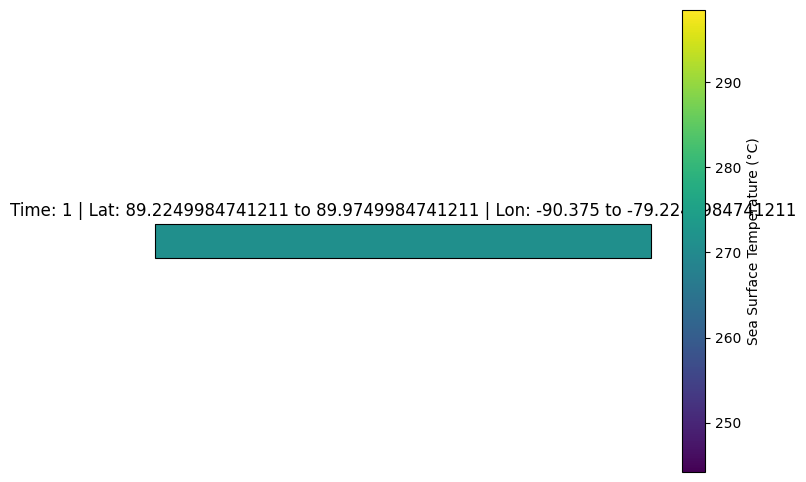

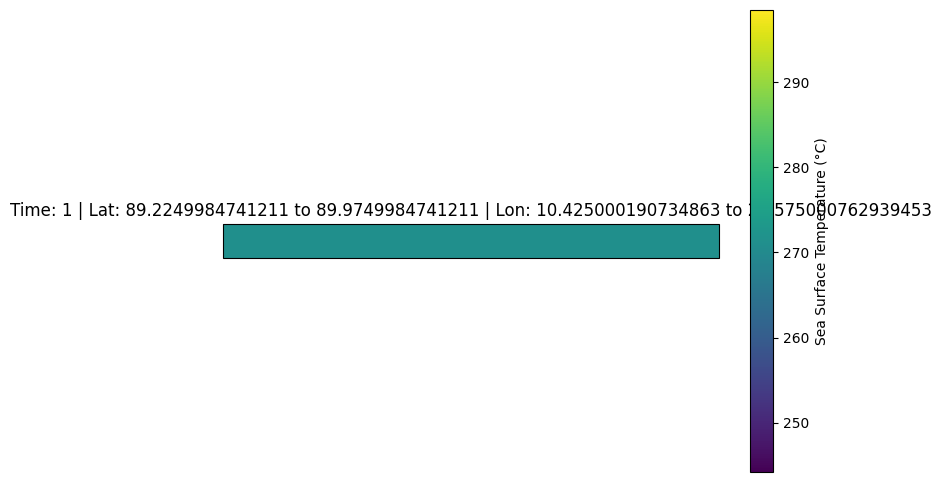

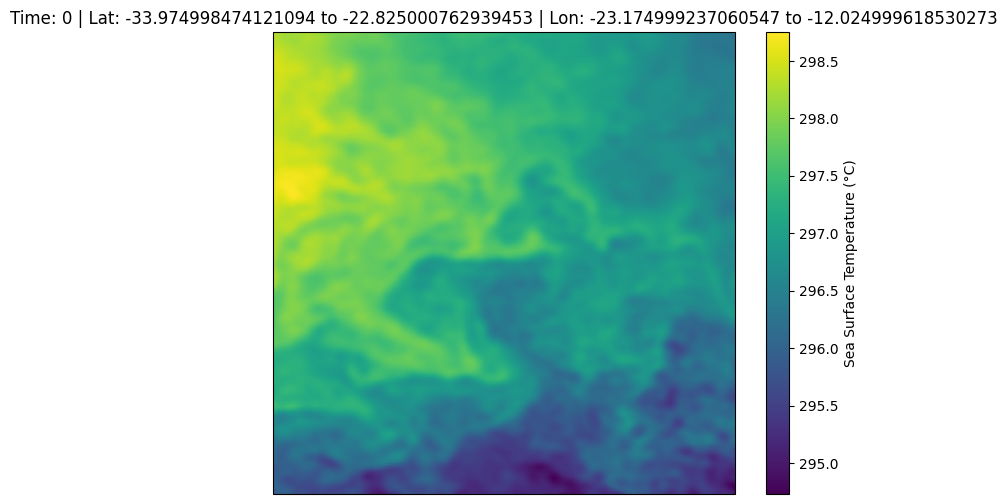

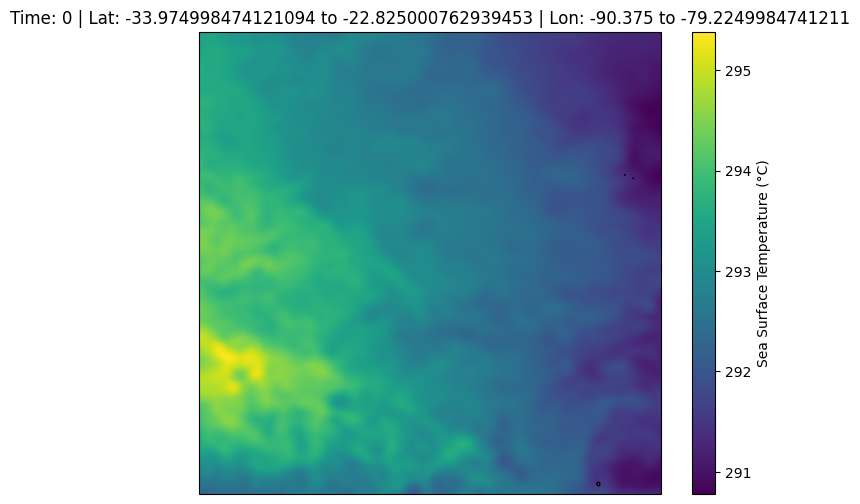

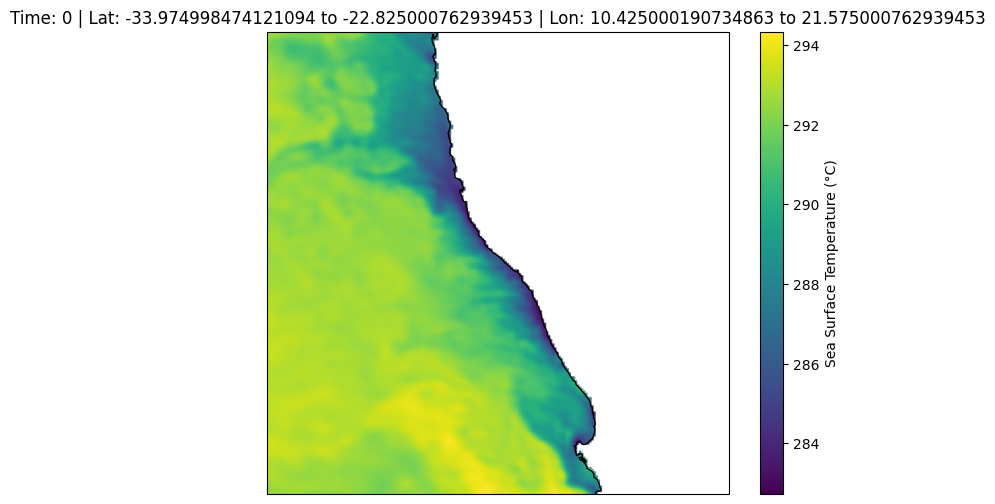

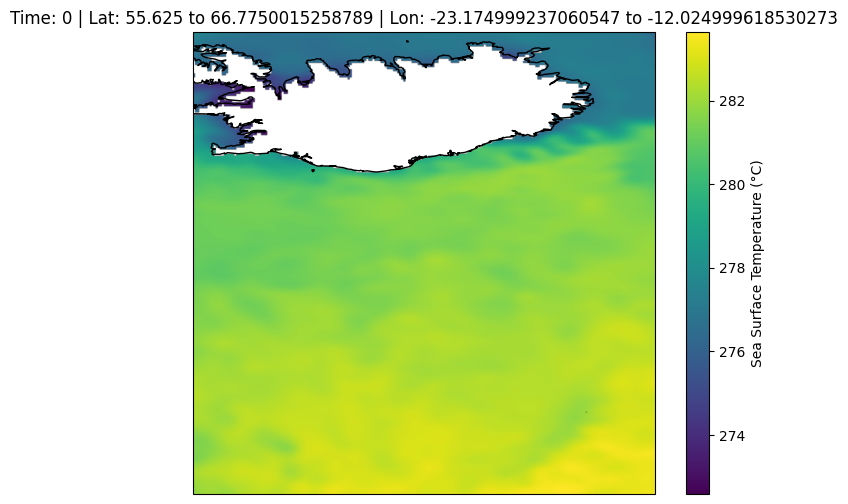

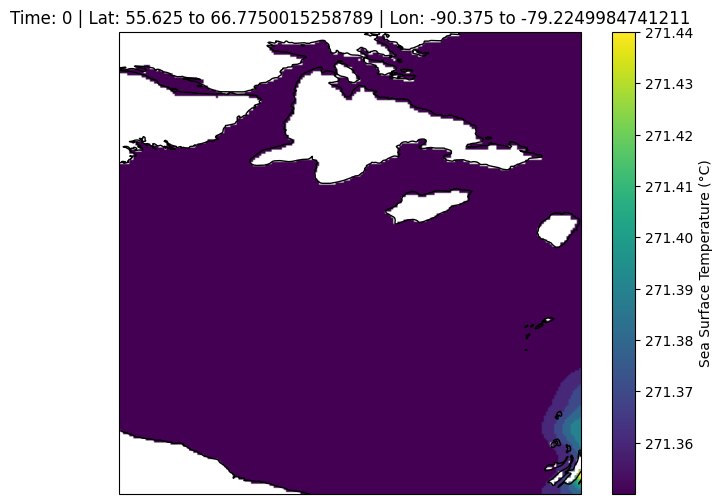

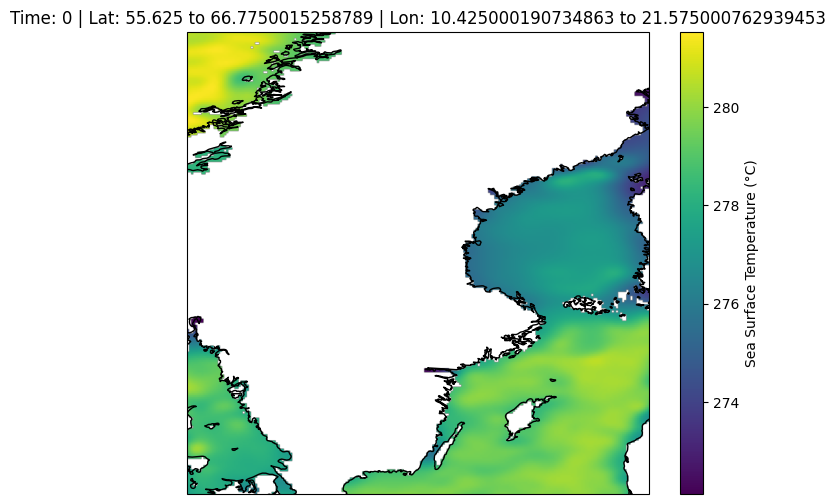

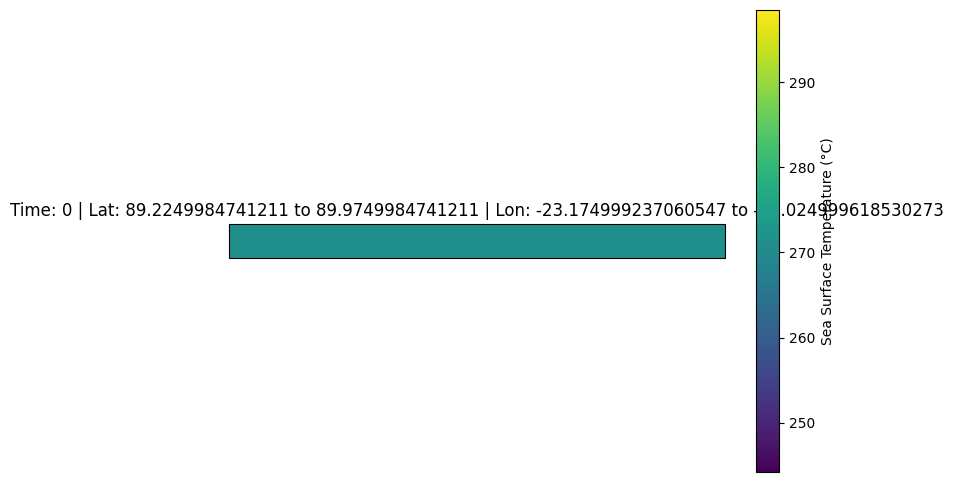

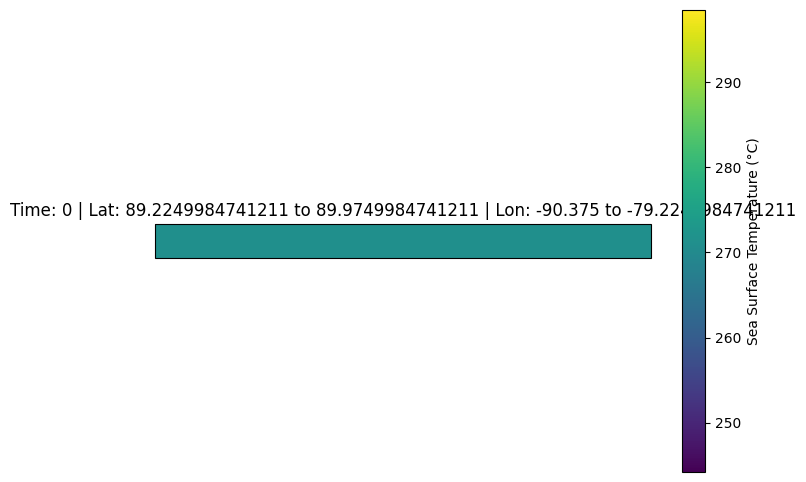

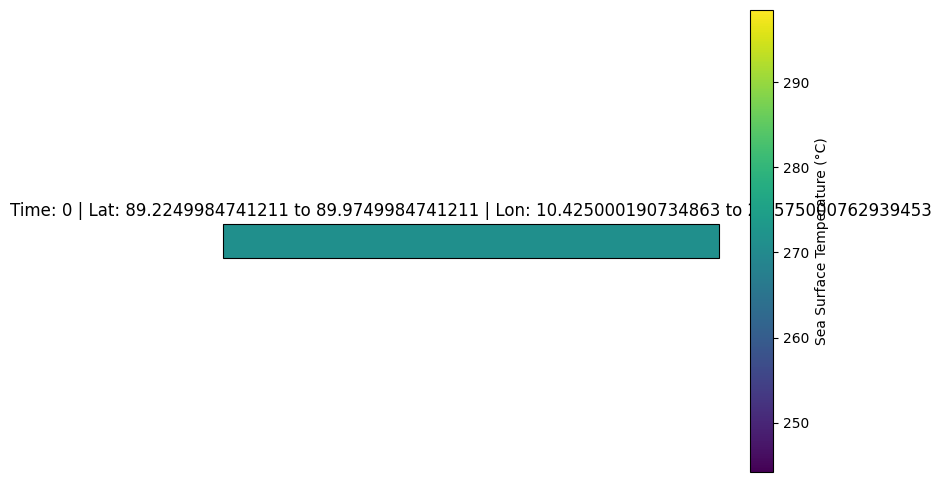

In [26]:
import zarr
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Open the Zarr store
store = zarr.open("tiles_output.zarr", mode="r")

# Get the shape of the dataset
time_len = store['analysed_sst'].shape[0]
lat_len = store['analysed_sst'].shape[1]
lon_len = store['analysed_sst'].shape[2]

# Randomly select a few tile indices
random_times = np.random.choice(time_len, size=3, replace=False)  # 3 random time steps
random_lat_idx = np.random.choice(lat_len, size=3, replace=False)  # 3 random latitude tiles
random_lon_idx = np.random.choice(lon_len, size=3, replace=False)  # 3 random longitude tiles

# Plot each random tile
for t_idx in random_times:
    for lat_idx in random_lat_idx:
        for lon_idx in random_lon_idx:
            # Retrieve the data, latitudes, and longitudes for the tile
            sst_tile = store['analysed_sst'][t_idx, lat_idx, lon_idx]
            lat_tile = store['latitudes'][t_idx, lat_idx, lon_idx]
            lon_tile = store['longitudes'][t_idx, lat_idx, lon_idx]

            # Plotting with Cartopy for coastlines
            fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={'projection': ccrs.PlateCarree()})
            ax.set_extent([lon_tile[0][0], lon_tile[-1][-1], lat_tile[0][0], lat_tile[-1][-1]], crs=ccrs.PlateCarree())
            
            # Plot the SST data
            im = ax.imshow(sst_tile, cmap='viridis', origin='lower', 
                           extent=[lon_tile[0][0], lon_tile[-1][-1], lat_tile[0][0], lat_tile[-1][-1]], 
                           transform=ccrs.PlateCarree())
            plt.colorbar(im, ax=ax, label='Sea Surface Temperature (°C)')
            
            # Add coastal lines
            ax.coastlines()

            # Title with coordinates
            ax.set_title(f'Time: {t_idx} | Lat: {lat_tile[0][0]} to {lat_tile[-1][-1]} | '
                         f'Lon: {lon_tile[0][0]} to {lon_tile[-1][-1]}')
            ax.set_xlabel('Longitude')
            ax.set_ylabel('Latitude')
            
            plt.show()
